In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft
import scipy.sparse
import time
from impedance import calculate_impedance
from plotting import nyquist_plot

# Linear diffusion example

In this example we use a simple diffusion problem to showcase the methodology for computing the impedance behaviour of a model. The model is

$$c_t = D c_{xx}, \quad \left. c_x \right|_{x=0} = 0, \quad \left. -Dc_x \right|_{x=1}=j, \quad \left. c \right|_{t=0}=c_0,$$

where $D$ is the (constant) diffusivity, $c_0$ the initial concentration, and $j(t) = \exp(i\omega t)$ the prescribed flux. We solve the problem on the interval $[0, 1]$. We assume that the problem has been non-dimensionalised and therefore do not worry about units.

We calculate the impedance as $\left. \hat{c}\right|_{x=1} / \hat{j}$ where a hat denotes the Fourier transform. We can calculate this by either simulating in the time domain and taking the FFT of the result, or by assuming a periodic solution and, after discretising in space, solving the resulting matrix problem.


Let's set up our model.

In [2]:
class Model(pybamm.BaseModel):
    def __init__(self, name="Linear diffusion model"):
        super().__init__(name=name)
        
        # Set time and length scales 
        self._timescale = pybamm.Scalar(1)
        self._length_scales = {"rod": pybamm.Scalar(1)}
        
        # variables
        c = pybamm.Variable("Concentration", domain="rod")        
        x = pybamm.SpatialVariable("x", domain="rod", coord_sys="cartesian")
        
        # parameters
        D = pybamm.Parameter("Diffusivity")
        c0 = pybamm.Parameter("Initial concentration")
        j = pybamm.FunctionParameter("Applied flux", {"Time": pybamm.t})

        # governing equations
        N = -D * pybamm.grad(c)  # flux
        dcdt = -pybamm.div(N)  # right hand side of the PDE
        self.rhs = {c: dcdt} 
        
        # boundary conditions
        self.boundary_conditions = {
            c: {
                "left": (pybamm.Scalar(0), "Neumann"),
                "right": (-j / D, "Neumann"),
            }
        }
        
        # initial conditions
        self.initial_conditions = {c: c0}

        # populate variables dict
        self.variables = {
            "Concentration": c,
            "Applied flux": j,
            "Time": pybamm.t,
        }
        
    @property
    def default_geometry(self):
        x = pybamm.SpatialVariable("x", domain="rod", coord_sys="cartesian")
        return {"rod": {x: {"min": pybamm.Scalar(0), "max": pybamm.Scalar(1)}}}

    @property
    def default_var_pts(self):
        x = pybamm.SpatialVariable("x", domain="rod", coord_sys="cartesian")
        return {x: 128}

    @property
    def default_submesh_types(self):
        return {"rod": pybamm.Uniform1DSubMesh}

    @property
    def default_spatial_methods(self):
        return {"rod": pybamm.FiniteVolume()}
    
    
        

Next we choose a range of frequencies to solve over

In [3]:
start_freq = 0.01
end_freq = 10
num_points = 20

omegas = np.exp(np.linspace(np.log(start_freq), np.log(end_freq), num_points))

## Solving in the time domain

Here we solve the problem by running a simulation in the time domain and taking the FFT of the result.

We first load an instance of our model

In [4]:
model = Model()

and define our parameters. We make the frequency an "input" that we will loop over.

In [5]:
def applied_flux(t):
    return pybamm.sin(pybamm.InputParameter("Frequency") * t)
    

parameter_values = pybamm.ParameterValues(
    {
        "Applied flux": applied_flux,
        "Diffusivity": 1,
        "Initial concentration": 1,
    },
)

Next we create our simulation

In [6]:
sim = pybamm.Simulation(model, parameter_values=parameter_values, solver=pybamm.ScipySolver())

We then loop over frequencies, solving the model and taking the FFT of the result to calculate the impedance.

In [7]:
samples_per_period = 128
num_periods = 5

zs_time = []
start_time = time.time()
for omega in omegas:
    skip_periods = int(np.floor(4*omega))
    total_periods = num_periods + skip_periods

    dt = 2 * np.pi / omega / samples_per_period
    t_eval = (np.array(range(0, 1 + samples_per_period * total_periods)) * dt)

    solution = sim.solve(t_eval, inputs={"Frequency": omega})

    t = solution["Time"].entries 
    c = solution["Concentration"].entries[-1, :]

    # FFT
    c0 = parameter_values["Initial concentration"]
    c_hat = scipy.fft.fft(c[skip_periods * samples_per_period :] - c0)
    x = np.linspace(0, 1 / dt, samples_per_period * num_periods)
    i = np.sin(omega * t)
    i_hat = scipy.fft.fft(i[skip_periods * samples_per_period :])
    # impedance using first harmonic
    index = np.argmax(np.abs(i_hat))
    z = -c_hat[index] / i_hat[index]
    zs_time.append(z)
end_time = time.time()
time_elapsed = end_time - start_time
print("Time domain method: ", time_elapsed, "s")

Time domain method:  16.546557188034058 s


We can make a Nyquist plot of the result

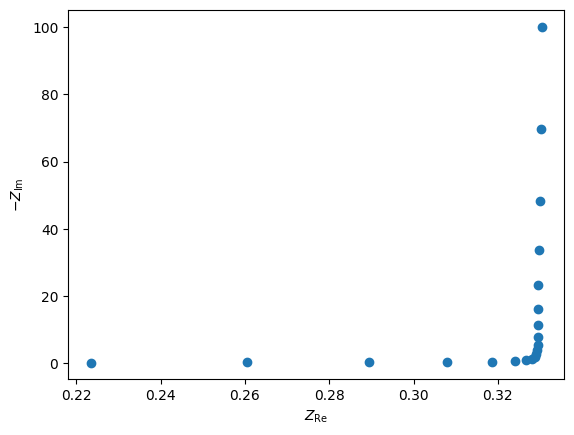

In [8]:
nyquist_plot(zs_time);

## Solve in the frequency domain

We are interested in solving the problem when there is periodic forcing $j=\hat{j}\mathrm{e}^{i\omega t}$. We look for a solution $c=\hat{c}\mathrm{e}^{i\omega t}$ so that our problem becomes 

$$i \omega \hat{c} = D \hat{c}_{xx}, \quad \left. \hat{c}_x \right|_{x=0} = 0, \quad \left. -D\hat{c}_x \right|_{x=1}=\hat{j}.$$

After discretisation using the finite volume method the problem will look like

$$ i \omega \boldsymbol{\hat{c}} = J \boldsymbol{\hat{c}} + \boldsymbol{b},$$

where

$$ 
J = \frac{D}{(\Delta x)^2} \begin{bmatrix}
-1 & 1 &  0 &  & & \\
1 & -2 & 1 &  & & \\
 & 1 & -2 & 1 & & \\
 &  & \ddots & \ddots & \ddots& \\
 &  & & 1 & -2 & 1  \\
 & &  & 0 & 1 & -1 
\end{bmatrix}
$$
and
$$
\boldsymbol{b} = \begin{bmatrix}
0 \\
\vdots \\
0 \\
-\hat{j}/\Delta x
\end{bmatrix}
$$

We can then solve this problem for different frequencies to calculate the impedance response. 

Let's load another instance of our model

In [9]:
model = Model()

and set the parameters. The flux is now just 1 since we have already assumed a periodic solution

In [10]:
parameter_values = pybamm.ParameterValues(
    {
        "Applied flux": 1,
        "Diffusivity": 1,
        "Initial concentration": 1,
    },
)

Next we create a simulation and "build" the model. This disretises the problem in space. We then "set up" the model using the solver - this stage calculates the mass matrix and Jacobian using automatic differentiation. 

In [11]:
sim = pybamm.Simulation(model, parameter_values=parameter_values)
sim.build()
model = sim.built_model
solver=pybamm.ScipySolver()
solver.set_up(model)

Now we are ready to construct the matrix problem

In [12]:
y0 = model.concatenated_initial_conditions.entries  # vector of initial conditions
J = model.jac_rhs_algebraic_eval(
    0, y0, []
).sparse()  #  call the Jacobian and return a (sparse) matrix

b = model.rhs_algebraic_eval(0, y0, [])
M = model.mass_matrix.entries

# Add an extra row with just one entry. This is important as the measured output must be
# the second to last entry and the forcing the last when using calculate_impedance.
# Doing this in this way is inefficient, but the problem is small enough that it's ok.
extra_entry = scipy.sparse.csr_matrix([[0]])
M = scipy.sparse.block_diag([M, extra_entry])
extra_entry[0, 0] = 1
J = scipy.sparse.block_diag([J, extra_entry])
size = np.shape(J)[0]
b = np.reshape(np.append(b, 1), [size, 1])

and solve, looping over frequencies,

In [13]:
start_time = time.time()
zs_freq, ws = calculate_impedance(M, J, b, start_freq, end_freq, num_points, method="direct")
end_time = time.time()
time_elapsed = end_time - start_time
print("Frequency domain method: ", time_elapsed, "s")

# TO DO zs_freq is a list of arrays, just return a list or an array
zs_freq = [z[0] for z in zs_freq]

Frequency domain method:  0.007929086685180664 s


Finally we can create a Nyquist plot

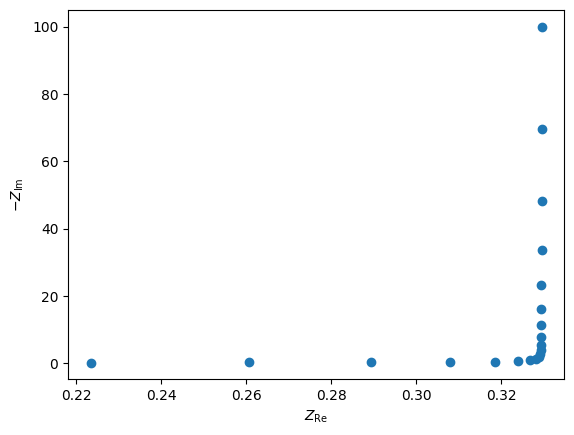

In [14]:
nyquist_plot(zs_freq);

## Compare

We can compare the results by plotting them both on the same axes

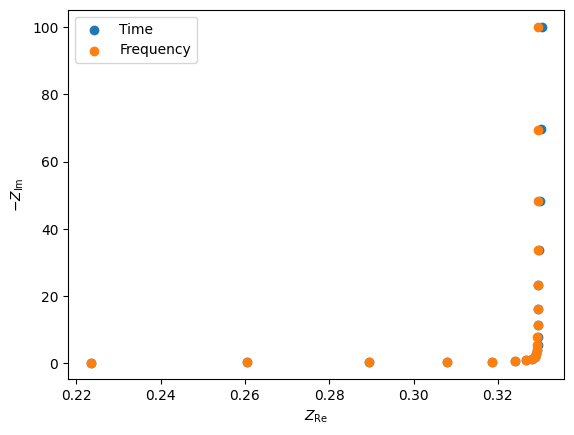

In [15]:
_, ax = plt.subplots();
ax = nyquist_plot(zs_time, ax=ax, label="Time");
ax = nyquist_plot(zs_freq, ax=ax, label="Frequency");
ax.legend()